In [ ]:
#!/usr/bin/env python3
#coding=utf-8

#  ______               _         _____      _ _ _                  _                 _         _    _  _____ _____
# |  ____|             | |       |  __ \    | (_| |                (_)               | |       | |  | |/ ____|  __ \
# | |__   ___  ___ ___ | | __ _  | |__) ___ | |_| |_ ___  ___ _ __  _  ___ __ _    __| | __ _  | |  | | (___ | |__) |
# |  __| / __|/ __/ _ \| |/ _` | |  ___/ _ \| | | __/ _ \/ __| '_ \| |/ __/ _` |  / _` |/ _` | | |  | |\___ \|  ___/
# | |____\__ | (_| (_) | | (_| | | |  | (_) | | | ||  __| (__| | | | | (_| (_| | | (_| | (_| | | |__| |____) | |
# |______|___/\___\___/|_|\__,_| |_|   \___/|_|_|\__\___|\___|_| |_|_|\___\__,_|  \__,_|\__,_|  \____/|_____/|_|
# ___________________________________________________________________________________________________________________
#                      Detecção e Croping por meio de YOLOv3 customizada e framework Darknet
# ___________________________________________________________________________________________________________________
#
#  9848836 - Bruna Okura
#  11913194 - Lucas Lima Emerêncio
#  11805742 - Yann Gazzolla dos Santos
# ___________________________________________________________________________________________________________________

In [ ]:
from PIL import Image
import os
import math
import cv2
import json
import subprocess
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive

# MAKING DARKNET

In [ ]:
# clone darknet repo
!git clone https://github.com/LucasEmerencio/darknet_mosquito

Cloning into 'darknet_mosquito'...
remote: Enumerating objects: 15889, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 15889 (delta 19), reused 35 (delta 11), pack-reused 15834 (from 1)
Receiving objects: 100% (15889/15889), 14.51 MiB | 11.17 MiB/s, done.
Resolving deltas: 100% (10686/10686), done.


In [ ]:
%cd darknet_mosquito

/content/darknet_mosquito


In [ ]:
#Se preferir utilizar a GPU, realizar essas mudanças, entrar na pasta darknet_mosquito e executar o codigo
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

In [ ]:
# make darknet (build)
#%cd darknet_mosquito
!make

#DETECÇÃO EM BATCH E CROPING COM ARQUIVO DE RESULTADOS

##IMPLEMENTAÇÃO DE CROPING

Código para pegar coordenadas se formato do arquivo for algum outro que não o padrão json

In [ ]:
def get_coordinates(result_file):
    coordinates = []
    with open(result_file, 'r') as file:
        for line in file:
            if '%' in line:  # Look for lines with detection info
                parts = line.strip().split()
                if len(parts) >= 10:
                    left_x = int(parts[3])
                    top_y = int(parts[5])
                    width = int(parts[7])
                    height = int(parts[9].rstrip(')'))  # Remove the closing parenthesis
                    coordinates.append((left_x, top_y, width, height))
    return coordinates

Código para pegar coordenadas de detecção múltipla em formato json

In [ ]:
def get_coordinates_json(result_file):
    coordinates = []

    with open(result_file, 'r') as file:
        data = json.load(file)  # Load the JSON data

        for frame in data:
            frame_id = frame["frame_id"]
            for obj in frame["objects"]:
                relative_coords = obj["relative_coordinates"]

                # Extract the relative coordinates
                center_x = relative_coords["center_x"]
                center_y = relative_coords["center_y"]
                width = relative_coords["width"]
                height = relative_coords["height"]

                # Add the coordinates and frame ID to the list
                coordinates.append({
                    "frame_id": frame_id,
                    "center_x": center_x,
                    "center_y": center_y,
                    "width": width,
                    "height": height
                })

    return coordinates

In [ ]:
def crop_and_resize_image(path, cx, cy, range_x, range_y, crop_path = None):
    # Load image
    image = cv2.imread(path)
    if image is None:
        print("Error: Image not found at the specified path.")
        return

    img_height, img_width = image.shape[:2]

    #Coordenadas Absolutas
    cx = int(cx * img_width)
    cy = int(cy * img_height)

    range_x = int(range_x * img_width)
    range_y = int(range_y * img_height)

    # Calculo do vértice superior esquerdo da caixa de crop
    x_start = int(cx - range_x / 2)
    y_start = int(cy - range_y / 2)

    # Assegurando que as dimensões de crop respeitam os limites da imagem
    x_start = max(0, x_start)
    y_start = max(0, y_start)
    x_end = min(img_width, x_start + range_x)
    y_end = min(img_height, y_start + range_y)

    # Crop the image
    cropped_image = image[y_start:y_end, x_start:x_end]

    # Resize cropped image to 512x512
    resized_image = cv2.resize(cropped_image, (224, 224), interpolation=cv2.INTER_CUBIC)

    #Salvamos a imagem com crop no diretório especificado se o caminho for passado para função
    if crop_path is not None:
      jpeg_filename = os.path.join(crop_path, f"{os.path.splitext(os.path.basename(path))[0]}.jpg")
      cv2.imwrite(jpeg_filename, resized_image)
      #print(f"Imagem salva em: {crop_path}")

    # Linhas abaixos são utilizadas para mostrar o resultado do crop. Para cropping in batch não é recomendável mostrar cada imagem croppada
    #plt.figure(figsize=(5, 5))
    #plt.axis("off")
    #plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    #plt.show()

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
try:
  result = subprocess.run(["./darknet", "detector", "test", "data/obj.data", "cfg/yolov3_custom2.cfg", "/content/gdrive/MyDrive/TCC/REPRODUÇÃO_DE_RESULTADOS/backup/yolov3_custom2_last.weights", "/content/gdrive/MyDrive/TCC/Rede_Definitiva/Fotos_Completas_atual/Aedes_Albopictus/zoomed_AA_E_100_1_M.jpg", "-thresh", "0.2", "-ext_output", "-out", "result.txt"], shell = False, check = True)
except subprocess.CalledProcessError as e:
    print(f"Error during batch processing: {e}")

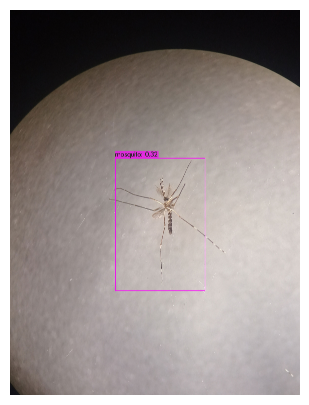

In [ ]:
imShow('predictions.jpg')

Criando arquivo contendo o caminho de cada imagem em uma classe

In [ ]:
input_dir = '/content/gdrive/MyDrive/TCC/Rede_Definitiva/Cropped/Test' #Substituir pelo caminho referente ao seu DRIVE

for dir in os.listdir(input_dir):
    print(f"Classe {dir}")
    dir_path = os.path.join(input_dir, dir)  # Full path to the subdirectory

    # Criando arquivo de path para cada imagem de cada diretório
    file_path = os.path.join(dir_path, "path_to_images.txt")

    with open(file_path, 'w') as file:
        for image in os.listdir(dir_path):
          extension = os.path.splitext(os.path.basename(image))[1]
          extension = extension.lower()
          if extension != '.jpg':
            continue
          img_path = os.path.join(dir_path, image)  # Full path to the image
          file.write(f"{img_path}\n")


Classe Aedes_fulvus
Classe Aedes_albopictus
Classe Aedes_scapularis
Classe Aedes_serratus
Classe Anopheles_bellator
Classe Mansonia_humeralis


Realizando a detecção de cada imagem presente em cada classe. O Arquivo result.txt, dentro da pasta de cada classe contém o resultado das detecções

In [ ]:
input_dir = '/content/gdrive/MyDrive/TCC/Rede_Definitiva/Cropped/Test' #Substituir pelo caminho referente ao seu DRIVE

for dir in os.listdir(input_dir):
  dir_path = os.path.join(input_dir, dir)  # Full path to the subdirectory
  images = os.path.join(dir_path, "path_to_images.txt")
  result_path = os.path.join(dir_path, "result.txt")
  # Comando a ser passado para subprocess
  command = [
      "./darknet", "detector", "test",
      "data/obj.data", "cfg/yolov3_custom2.cfg",
      "/content/gdrive/MyDrive/TCC/REPRODUÇÃO_DE_RESULTADOS/backup/yolov3_custom2_last.weights",
      "-thresh", "0.3", "-ext_output", "-dont_show", "-out", result_path
  ] #Substituir o caminho do arquivo .weights pelo equivalente no seu drive

  try:
      # Passando o caminho das imagens para o módulo de subprocess
      with open(images, 'r') as images_file:
          result = subprocess.run(
              command,
              stdin=images_file,
              text=True,
              check=True
          )
      print(f"Detecção completa para a classe: {dir}")
  except subprocess.CalledProcessError as e:
      print(f"Error ao processar classe {dir}: {e}")
  except FileNotFoundError:
      print(f"Missing path_to_images.txt in {dir_path}")


Detecção completa para a classe: Aedes_fulvus
Detecção completa para a classe: Aedes_albopictus
Detecção completa para a classe: Aedes_scapularis
Detecção completa para a classe: Aedes_serratus
Detecção completa para a classe: Anopheles_bellator
Detecção completa para a classe: Mansonia_humeralis


Com o arquivo de resultados de cada classe, podemos salvar as imagens recortadas na pasta desejada

In [ ]:
output_dir = '/content/gdrive/MyDrive/TCC/Rede_Definitiva/New_detection/Test' #Substituir caminho pelo equivalente no seu drive
input_dir = '/content/gdrive/MyDrive/TCC/Rede_Definitiva/Cropped/Test' #Substituir caminho pelo equivalente no seu drive

for dir in os.listdir(input_dir):
  print(f"Processando imagens de {dir}")
  dir_path = os.path.join(input_dir, dir) # Full path to the subdirectory

  crop_path = os.path.join(output_dir, dir) # Full path to the cropped directory
  if not os.path.exists(crop_path):
    os.makedirs(crop_path)

  result_path = os.path.join(dir_path, "result.txt") # Full path to the result.txt
  coordinates = get_coordinates_json(result_path)

  for i, image in enumerate(os.listdir(dir_path)):

    extension = os.path.splitext(os.path.basename(image))[1]
    extension = extension.lower()
    #Não queremos arquivos que não sejam imagens
    if extension != '.jpg':
      continue

    frame_id = i + 1

    coord = next((item for item in coordinates if item["frame_id"] == frame_id), None)

    image_path = os.path.join(dir_path, image) # Full path to the image
    if coord is None:
        print(f"Sem coordenadas encontradas para o frameID: {frame_id}")
        #VOCÊ PODE DECIDIR SALVAR AS IMAGENS SEM CROP SE NÃO FOREM DETECTADAS AS COORDENADAS AO DESCOMENTAR AS LINHAS ABAIXO

        #image = cv2.imread(image_path)
        #jpeg_filename = os.path.join(crop_path, f"{os.path.splitext(os.path.basename(image_path))[0]}.jpg")
        #cv2.imwrite(jpeg_filename, image)

        continue  # Skip

    #Centro em X, em Y, largura e altura da detecção
    cx, cy, width, height = (
      coord["center_x"],
      coord["center_y"],
      coord["width"],
      coord["height"]
    )
    #crop_path é facultativo, se for omitido as images não serão salvas em outro diretório
    crop_and_resize_image(image_path, cx, cy, width, height, crop_path)


Processando imagens de Aedes_fulvus
Processando imagens de Aedes_albopictus
Processando imagens de Aedes_scapularis
Sem coordenadas encontradas para o frameID: 1
Sem coordenadas encontradas para o frameID: 27
Processando imagens de Aedes_serratus
Processando imagens de Anopheles_bellator
Sem coordenadas encontradas para o frameID: 4
Processando imagens de Mansonia_humeralis


### Helper Functions



In [ ]:
# define helper functions
def imShow(path):
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(5, 5)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()